In [ ]:
import scipy.stats as sps
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from graphviz import Digraph

from statsmodels.stats.proportion import proportion_confint
from statsmodels.formula.api import ols

from catboost import CatBoostRegressor
from joblib import Parallel, delayed

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", font_scale=1, palette="Set2")

Вам <a href="https://disk.yandex.ru/d/d9uxKFsst-YBkA">выдана</a> часть информации о визитах пользователей на сайте Физтех.Статистики начиная с 2020 года по данным Яндекс.Метрики. Визит &mdash; последовательность действий пользователя на сайте, которая начинается на некоторой странице сайта, содержит в себе переходы по ссылкам (и другие действия), и заканчивается на какой-то, возможно, другой страницей сайта. Визит считается завершенным, если активность отсутствует в течение некоторого времени, обычно &mdash; 30 минут.

Описание полей доступно по <a href="https://yandex.ru/dev/metrika/doc/api2/logs/fields/visits.html">ссылке</a>.

Ознакомимся с данными, ответив на следующие вопросы.
1. Сколько всего визитов представлено в данных?
2. Когда совершены первый и последний визиты?
3. Постройте динамику количества визитов во времени по дням.
4. Сколько уникальных пользователей в данных?
5. Сколько в среднем один пользователь совершил визитов? Сколько максимально?
6. Постройте гистограмму глубины и продолжительности визитов.
7. Из каких стран больше пользователей?
8. Какие браузеры и операционные системы в топе?

___

Считаем данные

In [ ]:
data = pd.read_csv("../miptstats_metrica.tsv", sep="\t")
data.head()

,ym:s:visitID,ym:s:clientID,ym:s:dateTimeUTC,ym:s:startURL,ym:s:endURL,ym:s:pageViews,ym:s:visitDuration,ym:s:isNewUser,ym:s:bounce,ym:s:regionCountry,...,ym:s:browserCountry,ym:s:mobilePhone,ym:s:operatingSystemRoot,ym:s:browser,ym:s:browserEngine,ym:s:screenOrientation,ym:s:screenWidth,ym:s:screenHeight,ym:s:windowClientWidth,ym:s:windowClientHeight
0,1.801686e+19,1568056026568729022,2020-01-01 03:28:50,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,1,0,1,Russia,...,gb,NaN,gnu_linux,chrome,WebKit,2,1920,1080,1905,981
1,1.802359e+19,1577864187752491163,2020-01-01 10:36:27,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,9,215,1,0,Singapore,...,us,apple,ios_double,safari_mobile,WebKit,1,375,667,375,559
2,1.802460e+19,1567765219104836417,2020-01-01 11:40:44,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/jekyll/update/201...,2,88,0,0,Russia,...,ru,apple,ios_double,yandex_browser,WebKit,1,414,736,414,660
3,1.802475e+19,1576839432510419026,2020-01-01 11:50:13,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,19,0,0,China,...,ru,samsung,android,chromemobile,WebKit,1,412,892,412,756
4,1.802518e+19,1576246599115183097,2020-01-01 12:17:33,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/jekyll/update/201...,2,2,0,0,Russia,...,ru,NaN,gnu_linux,firefox,Gecko,2,1920,1080,913,942


In [ ]:
for column in data.columns:
    col = column.replace("ym:s:", "")
    data.rename(columns={column: col}, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387353 entries, 0 to 387352
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   visitID              387353 non-null  float64
 1   clientID             387353 non-null  uint64 
 2   dateTimeUTC          387353 non-null  object 
 3   startURL             387338 non-null  object 
 4   endURL               387338 non-null  object 
 5   pageViews            387353 non-null  int64  
 6   visitDuration        387353 non-null  int64  
 7   isNewUser            387353 non-null  int64  
 8   bounce               387353 non-null  int64  
 9   regionCountry        382478 non-null  object 
 10  regionCity           326661 non-null  object 
 11  networkType          43035 non-null   object 
 12  browserLanguage      327934 non-null  object 
 13  browserCountry       224983 non-null  object 
 14  mobilePhone          73354 non-null   object 
 15  operatingSystemRo

Изменим тип на дату.

In [ ]:
data["dateTimeUTC"] = pd.to_datetime(data["dateTimeUTC"])

## 1. Исследование данных

Решим пункты 1, 2, 4, 5.

In [ ]:
print(f"Количество визитов: {len(data)}")
print(f'Первый визит: {data["dateTimeUTC"].min()}')
print(f'Последний визит: {data["dateTimeUTC"].max()}')
print(f'Уникальных пользователей: {data["clientID"].nunique()}')

visits_count = data.groupby(by="clientID").count().iloc[:, 0].tolist()
print(f"В среднем пользователь совершает визитов: {np.mean(visits_count):.2f}")
print(f"Максимум совершено визитов: {np.max(visits_count)}")

Количество визитов: 387353
Первый визит: 2020-01-01 03:28:50
Последний визит: 2024-02-25 23:58:46
Уникальных пользователей: 162474
В среднем пользователь совершает визитов: 2.38
Максимум совершено визитов: 58700


Разобьем время посещение на дату и на час, а также выделим год и месяц

In [ ]:
data["hour"] = data["dateTimeUTC"].dt.hour
data["date"] = pd.to_datetime(data["dateTimeUTC"].dt.date)
data["year"] = data["date"].apply(lambda dt: dt.year)
data["month"] = data["date"].apply(lambda dt: dt.month)
data

,visitID,clientID,dateTimeUTC,startURL,endURL,pageViews,visitDuration,isNewUser,bounce,regionCountry,...,browserEngine,screenOrientation,screenWidth,screenHeight,windowClientWidth,windowClientHeight,hour,date,year,month
0,1.801686e+19,1568056026568729022,2020-01-01 03:28:50,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,1,0,1,Russia,...,WebKit,2,1920,1080,1905,981,3,2020-01-01,2020,1
1,1.802359e+19,1577864187752491163,2020-01-01 10:36:27,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,9,215,1,0,Singapore,...,WebKit,1,375,667,375,559,10,2020-01-01,2020,1
2,1.802460e+19,1567765219104836417,2020-01-01 11:40:44,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/jekyll/update/201...,2,88,0,0,Russia,...,WebKit,1,414,736,414,660,11,2020-01-01,2020,1
3,1.802475e+19,1576839432510419026,2020-01-01 11:50:13,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,19,0,0,China,...,WebKit,1,412,892,412,756,11,2020-01-01,2020,1
4,1.802518e+19,1576246599115183097,2020-01-01 12:17:33,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/jekyll/update/201...,2,2,0,0,Russia,...,Gecko,2,1920,1080,913,942,12,2020-01-01,2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387348,8.349148e+17,170889374781031580,2024-02-25 23:42:27,https://miptstats.github.io/,https://miptstats.github.io/,1,15,1,0,Russia,...,WebKit,1,384,832,384,756,23,2024-02-25,2024,2
387349,8.349555e+17,1706366044539443064,2024-02-25 23:45:02,https://miptstats.github.io/courses/python/09_...,https://miptstats.github.io/courses/python/09_...,1,0,0,1,Russia,...,WebKit,2,1600,900,1583,771,23,2024-02-25,2024,2
387350,8.350287e+17,1707574597556843446,2024-02-25 23:49:41,https://miptstats.github.io/courses/ad_fivt/ta...,https://miptstats.github.io/courses/ad_fivt/ta...,1,0,0,1,Russia,...,WebKit,2,1536,864,1519,729,23,2024-02-25,2024,2
387351,8.350809e+17,17088943799001288,2024-02-25 23:52:59,https://mipt-stats.gitlab.io/courses/python/05...,https://mipt-stats.gitlab.io/courses/python/05...,1,23,1,0,Russia,...,WebKit,1,393,851,393,687,23,2024-02-25,2024,2


#### Количество визитов по часам

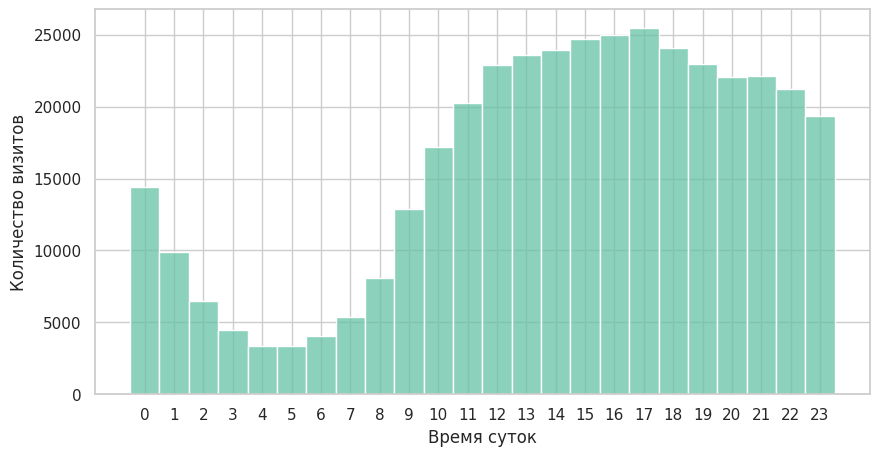

In [ ]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(10, 5))
    sns.histplot(data["hour"].astype(int), bins=range(25))
    plt.xlabel("Время суток")
    plt.ylabel("Количество визитов")
    plt.xticks(np.arange(24) + 0.5, range(24))
    plt.show()

#### Динамика количества визитов во времени по дням

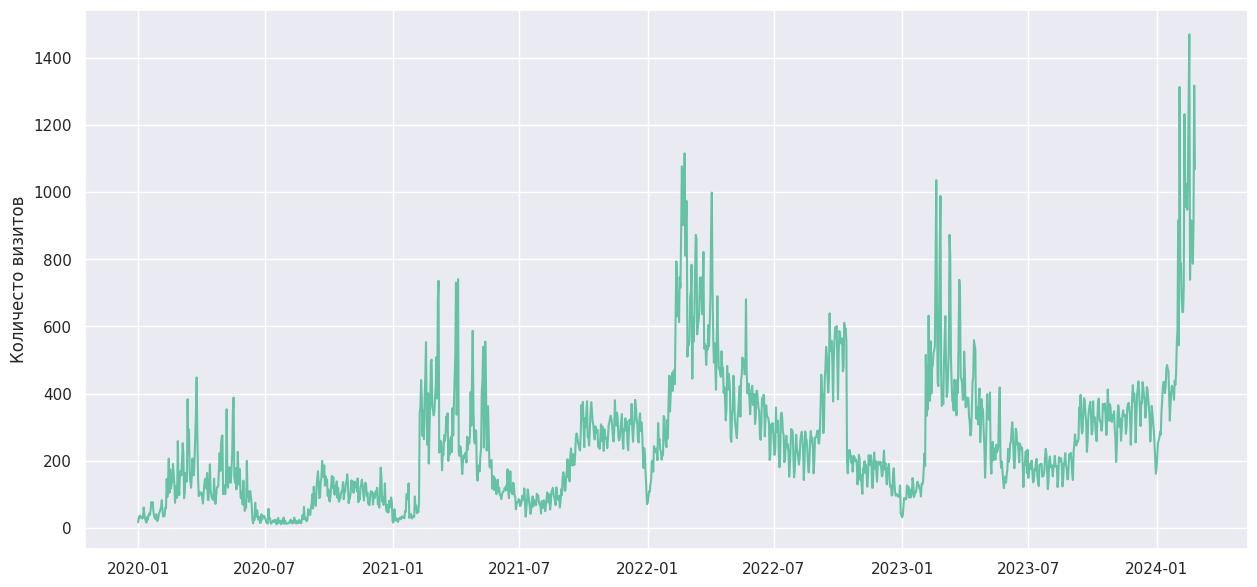

In [ ]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(15, 7))
    plt.plot(data.groupby(by="date").count()["clientID"])
    plt.ylabel("Количесто визитов")
    plt.show()

Можем наблюдать наличие пиков-выбросов во временных периодах

####  Глубина и длительность просмотров

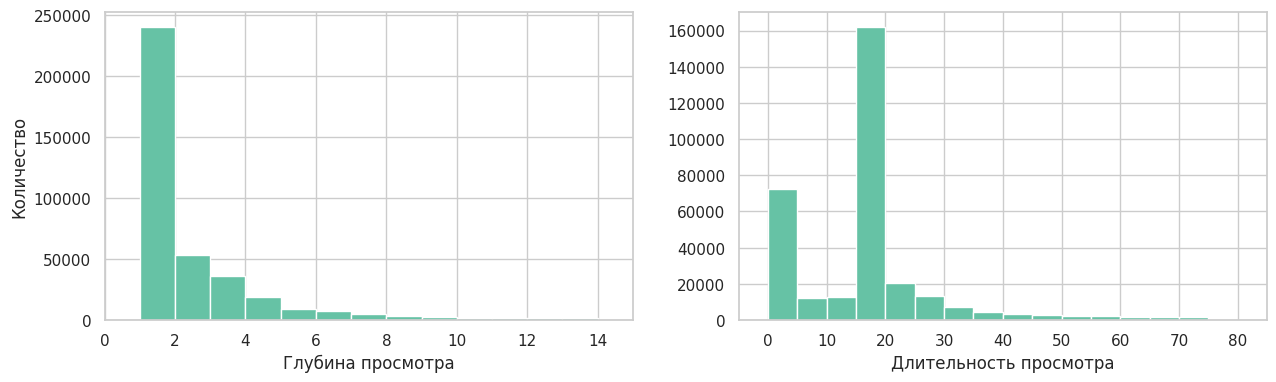

In [ ]:
with sns.axes_style("whitegrid"):
    _, axes = plt.subplots(1, 2, figsize=(15, 4))

    axes[0].hist(data["pageViews"], bins=np.arange(1, 15))
    axes[0].set_xlabel("Глубина просмотра")
    axes[0].set_ylabel("Количество")
    axes[0].set_xlim((0, 15))

    axes[1].hist(data["visitDuration"], bins=np.arange(0, 80, 5))
    axes[1].set_xlabel("Длительность просмотра")
    axes[1].set_xlim((-5, 85))

    plt.show()

Есть явно выбросные значения. Странно, что длительность просмотра часто находится в пределах 15-20, но в бинах рядом значения принимаются сильно реже.

#### Топ браузеров

Cразу же будем заменять редко встречающиеся значения на `other`.

Самые популярные браузеры


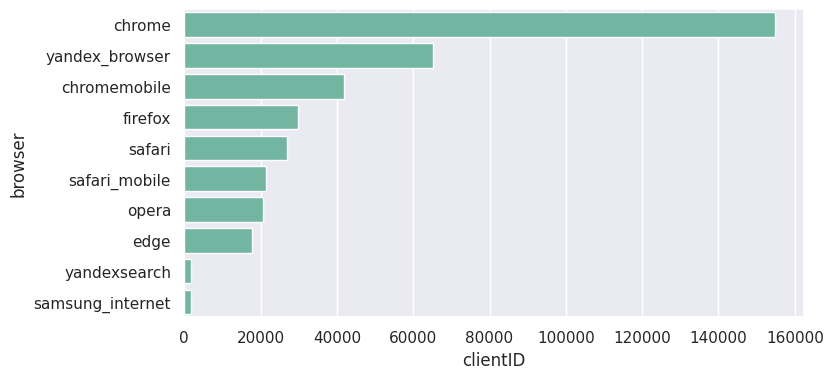

In [ ]:
print("Самые популярные браузеры")
data["browser"] = data["browser"].astype(str)
x = (
    data.groupby(by="browser")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(8, 4))
sns.barplot(x.iloc[:10], orient="h");

In [ ]:
browsers = [
    "chrome",
    "yandex_browser",
    "chromemobile",
    "firefox",
    "safari",
    "opera",
    "edge",
]
data.loc[~data["browser"].isin(browsers), "browser"] = "other"

#### Топ по странам

Самые частые страны


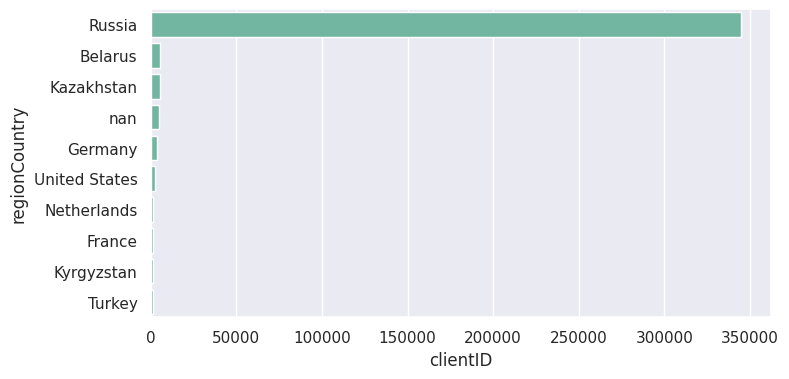

In [ ]:
print("Самые частые страны")
data["regionCountry"] = data["regionCountry"].astype(str)
x = (
    data.groupby(by="regionCountry")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(8, 4))
sns.barplot(x.iloc[:10], orient="h");

In [ ]:
data.loc[data["regionCountry"] != "Russia", "regionCountry"] = "other"
data

,visitID,clientID,dateTimeUTC,startURL,endURL,pageViews,visitDuration,isNewUser,bounce,regionCountry,...,browserEngine,screenOrientation,screenWidth,screenHeight,windowClientWidth,windowClientHeight,hour,date,year,month
0,1.801686e+19,1568056026568729022,2020-01-01 03:28:50,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,1,0,1,Russia,...,WebKit,2,1920,1080,1905,981,3,2020-01-01,2020,1
1,1.802359e+19,1577864187752491163,2020-01-01 10:36:27,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,9,215,1,0,other,...,WebKit,1,375,667,375,559,10,2020-01-01,2020,1
2,1.802460e+19,1567765219104836417,2020-01-01 11:40:44,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/jekyll/update/201...,2,88,0,0,Russia,...,WebKit,1,414,736,414,660,11,2020-01-01,2020,1
3,1.802475e+19,1576839432510419026,2020-01-01 11:50:13,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,19,0,0,other,...,WebKit,1,412,892,412,756,11,2020-01-01,2020,1
4,1.802518e+19,1576246599115183097,2020-01-01 12:17:33,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/jekyll/update/201...,2,2,0,0,Russia,...,Gecko,2,1920,1080,913,942,12,2020-01-01,2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387348,8.349148e+17,170889374781031580,2024-02-25 23:42:27,https://miptstats.github.io/,https://miptstats.github.io/,1,15,1,0,Russia,...,WebKit,1,384,832,384,756,23,2024-02-25,2024,2
387349,8.349555e+17,1706366044539443064,2024-02-25 23:45:02,https://miptstats.github.io/courses/python/09_...,https://miptstats.github.io/courses/python/09_...,1,0,0,1,Russia,...,WebKit,2,1600,900,1583,771,23,2024-02-25,2024,2
387350,8.350287e+17,1707574597556843446,2024-02-25 23:49:41,https://miptstats.github.io/courses/ad_fivt/ta...,https://miptstats.github.io/courses/ad_fivt/ta...,1,0,0,1,Russia,...,WebKit,2,1536,864,1519,729,23,2024-02-25,2024,2
387351,8.350809e+17,17088943799001288,2024-02-25 23:52:59,https://mipt-stats.gitlab.io/courses/python/05...,https://mipt-stats.gitlab.io/courses/python/05...,1,23,1,0,Russia,...,WebKit,1,393,851,393,687,23,2024-02-25,2024,2


#### Топ по ОС

Самые популярные ОС


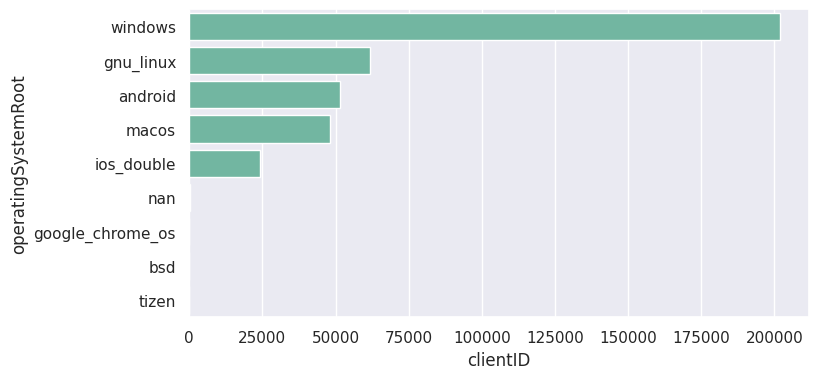

In [ ]:
print("Самые популярные ОС")
data["operatingSystemRoot"] = data["operatingSystemRoot"].astype(str)
x = (
    data.groupby(by="operatingSystemRoot")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(8, 4))
sns.barplot(x, orient="h");

In [ ]:
os = ["windows", "gnu_linux", "android", "macos", "ios_double"]
data = data[data["operatingSystemRoot"].isin(os)]

#### Ориентации экрана

Самые популярные ориентации экрана


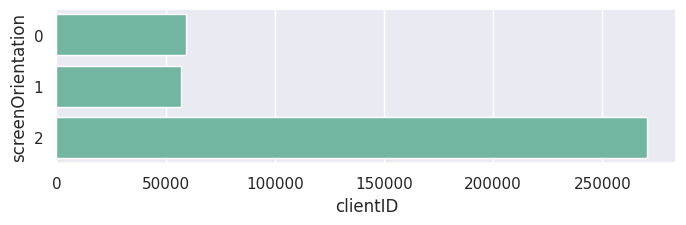

In [ ]:
print("Самые популярные ориентации экрана")
x = (
    data.groupby(by="screenOrientation")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(8, 2))
sns.barplot(x, orient="h");

#### Типы интернет-сетей

Самые популярные типы сетей


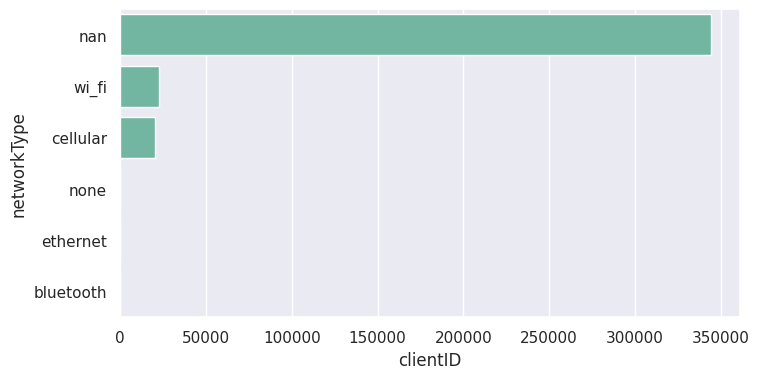

In [ ]:
print("Самые популярные типы сетей")
data["networkType"] = data["networkType"].astype(str)
x = (
    data.groupby(by="networkType")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(8, 4))
sns.barplot(x, orient="h");

In [ ]:
network_types = ["nan", "wi_fi", "cellular"]
data = data[data["networkType"].isin(network_types)]

#### Тип точки входа на сайт

Типы сайтов


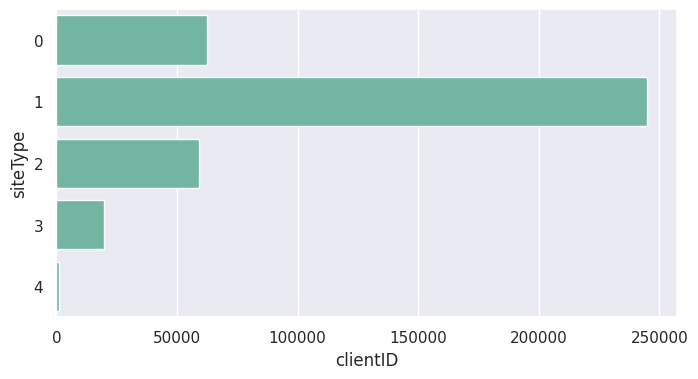

In [ ]:
site_types = []
data["startURL"] = data["startURL"].astype(str)

for i in range(len(data)):
    if "github.io" in data["startURL"].iloc[i]:
        site_types.append(0)
    elif "gitlab.io" in data["startURL"].iloc[i]:
        site_types.append(1)
    elif "wiki.yandex.ru" in data["startURL"].iloc[i]:
        site_types.append(2)
    elif "forms.yandex.ru" in data["startURL"].iloc[i]:
        site_types.append(3)
    else:
        site_types.append(4)

data["siteType"] = site_types

print("Типы сайтов")
x = (
    data.groupby(by="siteType")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(8, 4))
sns.barplot(x, orient="h");

In [ ]:
data = data[data["siteType"].isin([0, 1])]

Посмотрим на кол-во уникальных пользователей в каждом из месяцев.

In [ ]:
data_cnt = (
    data.groupby(["year", "month"])
    .agg({"clientID": pd.Series.nunique})
    .reset_index()
)
data_cnt["date_month"] = data_cnt.apply(
    lambda row: pd.to_datetime(f"""{row['year']}-{row['month']}-01"""), axis=1
)
data_cnt.set_index("date_month", inplace=True)
data_cnt

,year,month,clientID
date_month,,,
2020-01-01,2020,1,340
2020-02-01,2020,2,859
2020-03-01,2020,3,1060
2020-04-01,2020,4,744
2020-05-01,2020,5,823
2020-06-01,2020,6,432
2020-07-01,2020,7,240
2020-08-01,2020,8,293
2020-09-01,2020,9,581


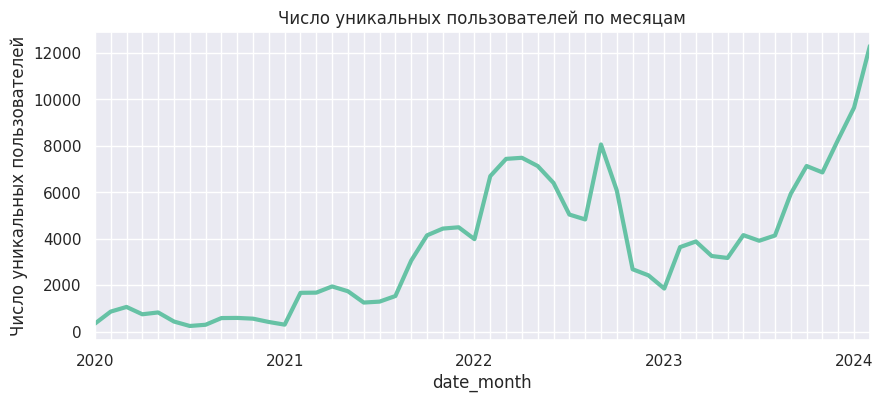

In [ ]:
plt.figure(figsize=(10, 4))
data_cnt["clientID"].plot(lw=3)
plt.ylabel("Число уникальных пользователей")
plt.title("Число уникальных пользователей по месяцам")
plt.xticks(pd.date_range(start="2020-01-01", end="2024-02-01", freq="M"))
plt.show()

Количество визитов по посетителям

In [ ]:
data.groupby(by="clientID")["visitID"].count().sort_values(ascending=False)

clientID
159631106194964144      525
1571345203385962128     379
1686212478710418142     286
167534681728506132      272
16456430291034906449    256
                       ... 
1663097040816887536       1
1663096684451168065       1
1663096176798996023       1
1663096086600001333       1
16910522111058091140      1
Name: visitID, Length: 152607, dtype: int64

Динамика целевой метрики

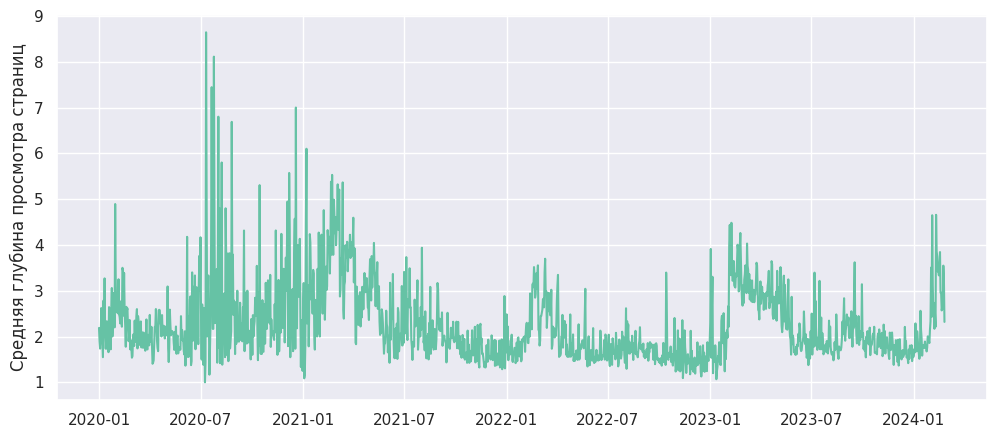

In [ ]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12, 5))
    plt.plot(data.groupby(by="date")["pageViews"].mean())
    plt.ylabel("Средняя глубина просмотра страниц")
    plt.show()

Выполним разделение на бакеты и проверьте, что количество пользователей в бакетах примерно одинаковое. Подумайте, как лучше выполнить такую проверку.

Возьмем начало 2024 и посмотрим, сколько там данных

In [ ]:
jan_data = data[(data["date"] >= "2024-01-01") & (data["date"] <= "2024-01-31")]
users_unique_jan = jan_data["clientID"].unique()
print(f"Уникальных пользователей в январе: {len(users_unique_jan)}")


feb_data = data[(data["date"] >= "2024-02-01") & (data["date"] <= "2024-02-29")]
users_unique_feb = feb_data["clientID"].unique()
print(f"Уникальных пользователей в феврале: {len(users_unique_feb)}")

Уникальных пользователей в январе: 9643
Уникальных пользователей в феврале: 12297


In [ ]:
test_control_size = 8_000  # пользователей в тесте+контроле
fraq_test = 0.5  # доля пользователей в тесте
# зададим промежуток времени, на котором валидируем
date_valid_start = pd.to_datetime("2024-01-01")
date_valid_end = pd.to_datetime("2024-02-29")
# зададим длительность теста
test_dlit = 28

target_column = "pageViews"
n_iter = 5_000
alpha = 0.05
n_jobs = 4

effects_list = np.linspace(0, 0.2, 21)

Определим кол-во бакетов как размер данных, поделенный на размер бакета.

In [ ]:
bs = 30

Провалидируем метод бакетов, проведя серию АА-тестов по историческим данным, семплируя момент времени начала эксперимента и сами группы пользователей.

## Обычный метод бакетов.

In [ ]:
def estimate_reject_prob(n_rejects, n_iter):
    """
    Оценка вероятности отвержения критерия и ее дов. интервала.
    Используется для оценки вероятности ошибки первого рода и мощности

    Аргументы:
    n_rejects -- количество отвержений H_0 в эксперименте
    n_iter -- количество экспериментов

    Возвращает:
    prob_reject -- оценка вероятности отвержения критерия
    left_bound, right_bound -- границы соотв. дов. интервала
    """

    prob_reject = n_rejects / n_iter
    left_bound, right_bound = proportion_confint(
        n_rejects, n_iter, method="wilson"
    )

    return prob_reject, left_bound, right_bound


def visualization(
    prob_reject,
    left_bound,
    right_bound,
    show_pvals=False,
    pvals=None,
    alpha=0.05,
    figsize=(7, 2),
    title=None,
):
    """
    Отрисовка интервала для вероятности отвержения критерия
    и гистограммы p-value (опционально)
    prob_reject -- оценка вероятности отвержения
    left_bound, right_bound -- границы доверительного интервала
    alpha -- теор вероятность ошибки первого рода
    show_pvals -- показывать ли распределение p-value
    pvals -- массив из p-value
    figsize -- размер фигуры matplotlib
    """

    # построение гистограммы p-value (опционально)
    if show_pvals:
        with sns.axes_style("whitegrid"):
            plt.figure(figsize=figsize)
            plt.subplot(1, 2, 1)
            plt.hist(
                pvals,
                bins=np.linspace(0, 1, 21),
                alpha=0.7,
                weights=np.ones(len(pvals)) / len(pvals),
            )
            plt.title("Распределение p-value")

    # отрисовка интервала для вероятности отвержения критерия
    with sns.axes_style("whitegrid"):
        if show_pvals:
            plt.subplot(1, 2, 2)
        else:
            plt.figure(figsize=figsize)
        plt.hlines(0, 0, 1, color="black", lw=2, alpha=0.6)
        plt.vlines(alpha, -1, 1, color="red", lw=5, linestyle="--", alpha=0.6)
        plt.fill_between(
            [left_bound, right_bound],
            [0.15] * 2,
            [-0.15] * 2,
            color="green",
            alpha=0.6,
        )
        plt.scatter(prob_reject, 0, s=300, marker="*", color="red")
        plt.xlim(
            (min(alpha, left_bound) - 1e-3, max(alpha, right_bound) + 1e-3)
        )
        plt.title(
            f"Доля отвержений = {100*prob_reject:.2f}%, "
            f"интервал ({100*left_bound:.2f}%, {100*right_bound:.2f}%)"
        )
        plt.suptitle(title)
        plt.ylim((-0.5, 0.5))
        plt.yticks([])
        plt.tight_layout()
        plt.show()


def draw_power(
    powers,
    left_powers,
    right_powers,
    effects_list=np.linspace(0, 0.1, 11),
    label=None,
    title="Графики мощности",
    new_figure=False,
):
    """
    Построение и отрисовка графика мощности критерия.

    Аргументы:
    effects -- сетка эффектов
    real_alpha -- оценка реальной мощности
    left_alpha, right_alpha -- границы соотв. дов. интервала
    title -- заголовок графика
    """

    if new_figure:
        plt.figure(figsize=(10, 4))

    plt.plot(effects_list, powers, label=label, lw=3)
    plt.fill_between(effects_list, left_powers, right_powers, alpha=0.3)

    if new_figure:
        plt.hlines(
            0.8,
            effects_list[0],
            effects_list[-1],
            color="black",
            alpha=0.5,
            label="Мощность 0.8 (пересечение — MDE)",
        )
    plt.legend()
    plt.xlabel("Размер относительного эффекта")
    plt.ylabel("Мощность")
    plt.title(title)

In [ ]:
def add_effect(x, effect, target_name="pilot", relative_effect=True):
    """
    Функция искусственного добавления эффекта в тестовую выборку

    Аргументы:
    x -- выборка
    effect -- добавляемый эффект

    Возвращает:
    x -- выборка с добавленным эффектом
    """

    x_copy = x.copy()
    if relative_effect:
        x_copy[target_name] *= 1 + effect
    else:
        x_copy[target_name] += effect

    return x_copy


def run_1_iteration(
    test,
    generate_samples,
    target_name,
    add_effect,
    effects_list=[0],
    relative_effect=True,
):
    """
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_samples -- функция для семплирования выборок
    add_effect -- функция добавления эффекта
    effects_list --  массив размеров добавляемого эффекта (для оценки мощности)
    relative_effect -- является ли эффект относительным или абсолютным

    Возвращает: pvalue
    """
    # Генерируем выборки
    x_data, y_data = generate_samples(data=data)

    pvals = []
    for effect in effects_list:
        # Добавляем эффект, если хотим оценить мощность
        x_data_cp = add_effect(
            x_data,
            effect,
            target_name=target_name,
            relative_effect=relative_effect,
        )
        # Применяем критерий
        pvals.append(test(x_data_cp, y_data)[1])
    return pvals


def run_experiments(
    test,
    generate_samples,
    data=None,
    add_effect=add_effect,
    n_iter=10000,
    sample_size=1000,
    effect=0,
    relative_effect=True,
    n_jobs=4,
    alpha=0.05,
    target_name="pilot",
    draw=False,
    title=None,
    show_pvals=True,
):
    """
    Проведение серии AA-тестов на исторических данных.

    Аргументы:
    test -- статистический критерий
    generate_samples -- функция для семплирования выборок
    data -- исторические данные
    n_iter -- количество итераций
    sample_size -- размер выборок
    add_effect -- функция добавления эффекта
    effect -- размер добавляемого эффекта (для оценки мощности)
    relative_effect -- является ли эффект относительным или абсолютным
    alpha -- теор вероятность ошибки первого рода
    target_name -- имя колонки с таргет-метрикой
    """

    # Проведение серии экспериментов
    pvals = Parallel(n_jobs=n_jobs)(
        delayed(run_1_iteration)(
            test,
            generate_samples,
            target_name,
            add_effect,
            [effect],
            relative_effect,
        )
        for _ in tqdm(range(n_iter), leave=False)
    )
    pvals = np.array(pvals).flatten()
    # Подсчет числа отвержений
    n_rejects = (pvals < alpha).sum()

    # Оценка вероятности отвержения
    prob_reject, left_bound, right_bound = estimate_reject_prob(
        n_rejects, n_iter
    )

    # Визуализация
    if draw:
        figsize = (14, 3) if show_pvals else (5, 2)
        visualization(
            prob_reject,
            left_bound,
            right_bound,
            show_pvals,
            pvals,
            alpha,
            figsize,
            title,
        )

    return prob_reject, (left_bound, right_bound)


def estimate_power(
    test,
    generate_samples,
    data=None,
    n_jobs=4,
    n_iter=10000,
    sample_size=1000,
    effects_list=np.linspace(0, 0.1, 11),
    relative_effect=True,
    alpha=0.05,
    target_name="pilot",
):
    """
    Проведение серии AA-тестов на исторических данных с добавением разных эффектов.

    Аргументы:
    test -- статистический критерий
    generate_samples -- функция для семплирования выборок
    data -- исторические данные
    n_iter -- количество итераций
    sample_size -- размер выборок
    add_effect -- функция добавления эффекта
    effect -- размер добавляемого эффекта (для оценки мощности)
    relative_effect -- является ли эффект относительным или абсолютным
    alpha -- теор вероятность ошибки первого рода
    target_name -- имя колонки с таргет-метрикой
    """
    # Проведение серии экспериментов
    pvals = Parallel(n_jobs=n_jobs)(
        delayed(run_1_iteration)(
            test,
            generate_samples,
            target_name,
            add_effect,
            effects_list,
            relative_effect,
        )
        for _ in tqdm(range(n_iter), leave=False)
    )

    # Подсчет числа отвержений
    n_rejects = (np.array(pvals) < alpha).sum(axis=0)

    # Оценка мощности
    powers, left_bounds, right_bounds = estimate_reject_prob(n_rejects, n_iter)

    return powers, left_bounds, right_bounds

Напишем функцию генерации данных и составления бакетов, а также бакет-преобразование.

In [ ]:
def bucket_transform(data, bucket_size=bs, target_name="pageViews"):
    """
    Создает бакеты из данных.

    data -- таблица с полями clientID
    bucket_size -- размер бакетов
    target_name -- колонка с таргет-метрикой
    """
    num_buckets = int(len(data) / bucket_size)
    data_cp = data.copy()
    data_cp["bucket"] = data_cp["clientID"].apply(
        lambda x: np.abs(hash(x)) % num_buckets
    )
    return data_cp.groupby(by="bucket")[[target_name]].mean(), num_buckets

In [ ]:
def generate_subarray_bucket(
    data,
    bucket_size=bs,
    strat=False,
    date_valid_start=date_valid_start,
    date_valid_end=date_valid_end,
    test_dlit=test_dlit,
    test_control_size=test_control_size,
    fraq_test=fraq_test,
    target_name="pageViews",
):
    """
    Составление бакетов
    Генерация выборок 2-x групп посредством случайного деления пользователей на 2 группы
    Агрегация данных по пользователям

    Аргументы:
    data -- данные
    bucket_transform_fn -- функция бакет-преобразования (обычное, стратифицированное)
    nums_buckets -- число/массив кол-ва бакетов по стратам
    date_valid_start, date_valid_end -- временные границы валидации
    test_dlit -- длительность истории, которую берем в тест
    test_control_size -- размер теста+контроля
    fraq_test -- доля тестовой группы
    target_name -- имя колонки с таргет-метрикой

    Возвращает:
    test, control -- тестовая и контрольная группы
    """
    # определяем временные границы теста
    all_days = (date_valid_end - date_valid_start).days - test_dlit
    diff_from_start = np.random.choice(all_days, 1)[0]
    start_date = date_valid_start + pd.to_timedelta(diff_from_start, "D")
    end_date = start_date + pd.to_timedelta(test_dlit, "D")

    # берем нужный срез данных по времени
    data_start_end = data[
        (data["date"] >= start_date) & (data["date"] < end_date)
    ]

    # из всех пользователей выбираем сколько нужно
    users = data_start_end["clientID"].unique()
    users_test_control = np.random.choice(
        users, test_control_size, replace=False
    )
    data_test_control = data_start_end[
        data_start_end["clientID"].isin(users_test_control)
    ]

    # делаем бакет-преобразование
    bucket_transform_fn = (
        bucket_transform if not strat else strats_bucket_transform
    )
    data_bucket, nums_buckets = bucket_transform_fn(data_test_control)

    # делим бакеты на тест и контроль
    sampler = random_sampler if not strat else stratified_sampler
    test_groupped, control_groupped = sampler(
        data_bucket, len(data_bucket), fraq_test=fraq_test
    )

    return test_groupped, control_groupped

In [ ]:
def random_sampler(data, sample_size, fraq_test=0.5):
    """
    Случайное семплирование двух групп одного размера из данных.

    :param data: исходные данные
    :param sample_size: общий размер данных
    :param fraq_test: доля теста
    :return: две группы данных
    """

    choiced = data.sample(n=sample_size)
    test_size = int(sample_size * fraq_test)
    return choiced.iloc[:test_size], choiced.iloc[test_size:]

Проверим работу

In [ ]:
test_groupped, control_groupped = generate_subarray_bucket(data)
test_groupped

,pageViews
bucket,
185,3.025641
68,2.160000
277,3.863636
213,3.423077
43,2.652174
...,...
74,1.150000
141,1.230769
376,4.511364


Провалидируем t-test с бакетами

T-test с бакетами


  0%|          | 0/5000 [00:00<?, ?it/s]

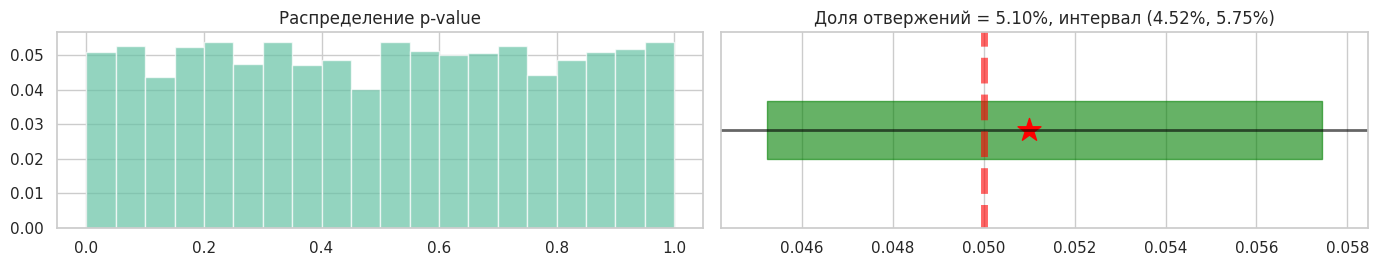

In [ ]:
tests = [lambda x, y: sps.ttest_ind(x[target_column], y[target_column])]
names = ["T-test с бакетами"]
for test, name in zip(tests, names):
    print(name)
    run_experiments(
        test=test,
        generate_samples=generate_subarray_bucket,
        target_name=target_column,
        data=data,
        sample_size=test_control_size,
        n_iter=n_iter,
        alpha=alpha,
        show_pvals=True,
        draw=True,
        n_jobs=n_jobs,
    );

  0%|          | 0/5000 [00:00<?, ?it/s]

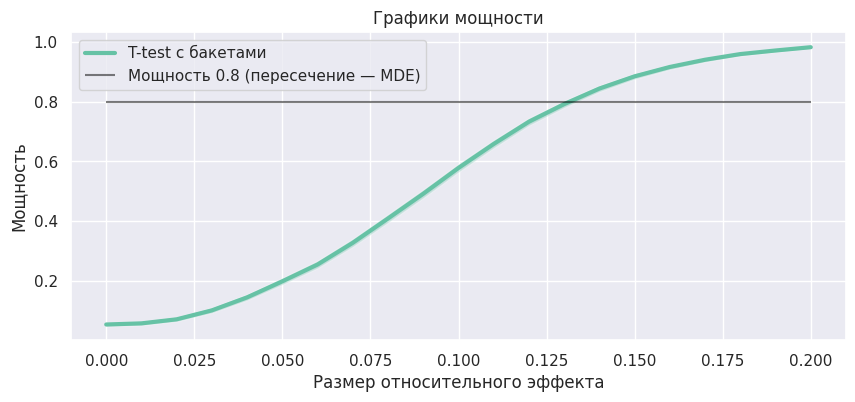

In [ ]:
tests = [lambda x, y: sps.ttest_ind(x[target_column], y[target_column])]
names = ["T-test с бакетами"]

for i, (test, name) in enumerate(zip(tests, names)):
    powers, left_bounds, right_bounds = estimate_power(
        test=test,
        generate_samples=generate_subarray_bucket,
        target_name=target_column,
        effects_list=effects_list,
        data=data,
        sample_size=test_control_size,
        n_iter=n_iter,
        alpha=alpha,
        n_jobs=n_jobs,
    )
    draw_power(
        powers,
        left_bounds,
        right_bounds,
        effects_list=effects_list,
        label=name,
        new_figure=(i == 0),
    )

**Вывод:** t-test с бакетами работает корректно, однако на меньшей мощности, чем обычный t-test.

Теперь рассмотрим стратификацию по операционной системе. Выполните разделение на бакеты внутри каждой страты и проверьте равномерность разбиения.

Учтите, что в одном бакете должны быть пользователи только из одной страты, тем самым стратификация возможна на выборке бакетов.

## Стратифицированный метод бакетов.

Скопируем функции для стратификации, а также напишем стратифицированное бакет-преобразование.

In [ ]:
def calculate_strata_weights(data):
    """
    Вычисляет веса страт.

    :param data: исходные данные
    :return: веса страт
    """

    strata_weights = data.groupby(by="strata")["sample"].count()
    strata_weights = strata_weights / strata_weights.sum()
    return strata_weights


def weighted_mean(data, weights):
    """
    Вычисляет взвешенное среднее.

    :param data: данные
    :param weights: веса страт
    :return: взвешенное среднее
    """

    strata_means = data.groupby(by="strata")["sample"].mean()
    return (strata_means * weights).sum()


def stratified_sampler(data, sample_size, fraq_test=0.5):
    """
    Стратифицированное семплирование выборок.

    :param data: данные
    :param sample_size: общий размер данных
    :param fraq_test: доля теста
    :return: две выборки
    """

    groupped = data.groupby(by="strata")

    # Веса страт
    strata_weights = calculate_strata_weights(data)
    strats = data["strata"].unique()

    # Размер выборок
    strata_sample_size = np.floor(sample_size * strata_weights + 0.5).astype(
        int
    )

    a_group, b_group = [], []
    # Генерируем для каждой страты отдельно
    for i, strata in enumerate(strats):
        a, b = random_sampler(
            data.loc[data["strata"] == strata],
            strata_sample_size[i],
            fraq_test=fraq_test,
        )
        a_group.append(a)
        b_group.append(b)

    return pd.concat(a_group), pd.concat(b_group)


def weighted_var(data, strata_weights):
    """
    Вычисляет взвешенную дисперсию при стратификации.

    :param data: данные
    :param strata_weights: веса страт
    :return: дисперсия
    """

    strata_vars = data.groupby(by="strata")["sample"].var()
    return (strata_vars * strata_weights).sum() / len(data)


def weighted_post_var(data, strata_weights):
    """
    Вычисляет взвешенную дисперсию при постстратификации.

    :param data: данные
    :param strata_weights: веса страт
    :return: дисперсия
    """

    strata_vars = data.groupby(by="strata")["sample"].var()
    weighted_var = (strata_vars * strata_weights).sum() / len(data)
    post_addition = (strata_vars * (1 - strata_weights)).sum() / (
        len(data) ** 2
    )
    return weighted_var + post_addition


def simple_var(data, strata_weights):
    """
    Вычисляет обычную дисперсию при случайном семплировании.

    :param data: данные
    :param strata_weights: веса страт, не используется, нужен для совместимости
    :return: дисперсия
    """

    return data["sample"].var() / len(data)

In [ ]:
def stratified_ttest(x_data, y_data, method="random", alpha=0.05):
    """
    Стратифицированный абсолютный t-test.

    :param x_data: выборка вместе с информацией о стратах
    :param y_data: выборка вместе с информацией о стратах
    :param strata_weights: веса страт
    :param method: метод 'random', 'stratified', 'post_stratified'
    :param alpha: уровень значимости
    :return: статистика критерия, границы доверительного интервала, p-value
    """

    if method == "random":
        mean_function = simple_mean
        var_function = simple_var
    elif method == "stratified":
        mean_function = weighted_mean
        var_function = weighted_var
    elif method == "post_stratified":
        mean_function = weighted_mean
        var_function = weighted_post_var

    strata_weights = calculate_strata_weights(pd.concat([x_data, y_data]))

    x_mean = mean_function(x_data, strata_weights)
    y_mean = mean_function(y_data, strata_weights)
    x_var = var_function(x_data, strata_weights)
    y_var = var_function(y_data, strata_weights)

    stat = x_mean - y_mean
    std = np.sqrt(x_var + y_var)

    t_stat = stat / std
    pvalue = 2 * sps.norm.sf(np.abs(t_stat))

    q = sps.norm.ppf(1 - alpha / 2)
    left_bound = stat - q * std
    right_bound = stat + q * std

    return stat, pvalue, left_bound, right_bound

In [ ]:
def strats_bucket_transform(data, bucket_size=bs, target_name="sample"):
    """
    Создает бакеты из данных по стратам.

    data -- таблица с полями clientID
    bucket_size -- размер бакета
    target_name -- колонка с таргет-метрикой
    """
    # считаем кол-во бакетов в данных
    nums_buckets = np.floor(
        data.groupby("operatingSystemRoot")["clientID"].count() / bs
    ).astype(int)
    # переименуем колонки для совместимости
    names = {"operatingSystemRoot": "strata", "pageViews": target_name}
    data = data.rename(columns=names)

    # делаем стратифицированное бакет-преобразование
    shifts = [0] + nums_buckets.cumsum().tolist()
    strats = nums_buckets.index
    result_data = []
    # проходимся по стратам
    for strata, num_buckets, shift in zip(strats, nums_buckets, shifts):
        # делаем бакет-преобразование
        df = data.loc[data["strata"] == strata]
        df_cp = df.copy()
        df_cp["bucket"] = df_cp["clientID"].apply(
            lambda x: np.abs(hash(x)) % num_buckets
        )
        result_data.append(df_cp)
    bucket_data = pd.concat(result_data)
    return (
        bucket_data.groupby(by=["strata", "bucket"])[target_name]
        .mean()
        .reset_index(),
        nums_buckets,
    )

Посмотрим, как работает стратифицированное сэмплирование по бакетам.

In [ ]:
test_groupped, control_groupped = generate_subarray_bucket(data, strat=True)
test_groupped

,strata,bucket,sample
43,android,43,1.633333
50,android,50,1.724138
135,android,135,1.432432
123,android,123,1.700000
26,android,26,1.833333
...,...,...,...
312,windows,114,2.718750
248,windows,50,3.090909
244,windows,46,2.000000
251,windows,53,1.333333


Провалидируйте метод бакетов со стратификацией.

T-test с бакетами и стратификацией


  0%|          | 0/2000 [00:00<?, ?it/s]

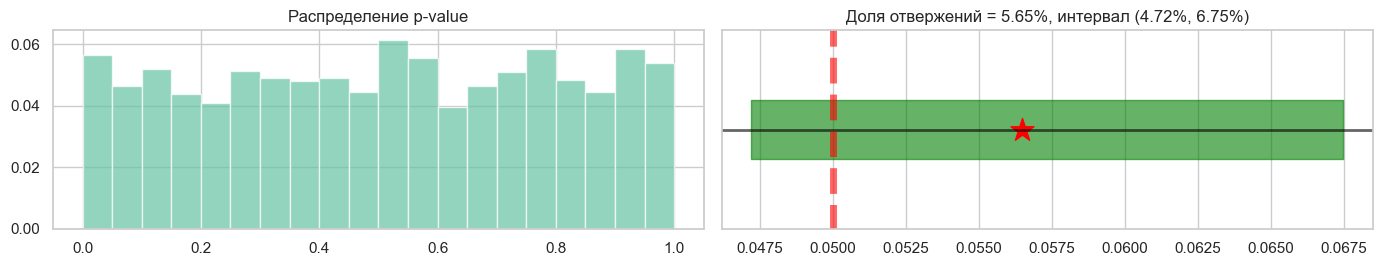

In [ ]:
tests = [lambda x, y: stratified_ttest(x, y, method="stratified")]
names = ["T-test с бакетами и стратификацией"]
target_column = "sample"

for test, name in zip(tests, names):
    print(name)
    run_experiments(
        test=test,
        generate_samples=lambda data: generate_subarray_bucket(
            data, strat=True
        ),
        target_name=target_column,
        data=data,
        add_effect=add_effect,
        sample_size=test_control_size,
        n_iter=n_iter,
        alpha=alpha,
        show_pvals=True,
        draw=True,
        n_jobs=n_jobs,
    );

  0%|          | 0/1000 [00:00<?, ?it/s]

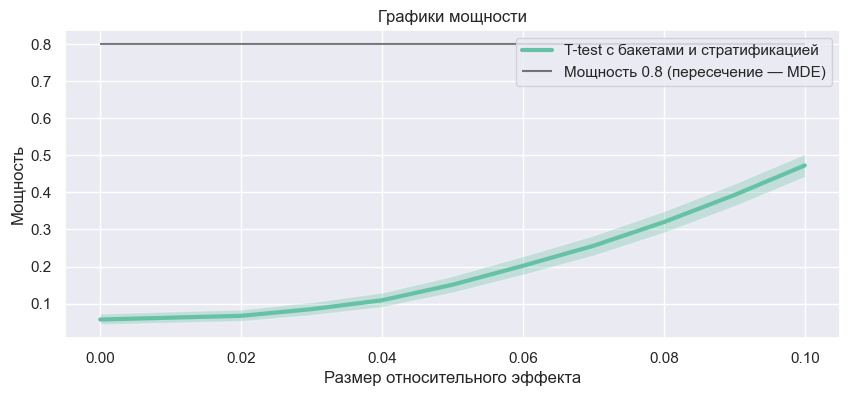

In [ ]:
for i, (test, name) in enumerate(zip(tests, names)):
    powers, left_bounds, right_bounds = estimate_power(
        test=test,
        generate_samples=lambda data: generate_subarray_bucket(
            data, strat=True
        ),
        target_name=target_column,
        data=data,
        n_iter=n_iter,
        alpha=alpha,
        n_jobs=n_jobs,
    )
    draw_power(
        powers, left_bounds, right_bounds, label=name, new_figure=(i == 0)
    )

**Выводы:** мы протестировали на исторических данных метод бакетов и метод бакетов со стратификацией. Оба метода оказались корректными, по мощности оба метода не детектируют эффект в 10% на мощности 0.8.